In [1]:
import platform

print(platform.machine())

arm64


In [2]:
import io
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pathlib

import time
from selenium import webdriver
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
        data = np.asarray([dataset[i][0] for i in range(len(dataset))])
        print(data.shape)
        print(labels.shape)
        
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        
        data = np.moveaxis(data, 3, 1)
        self.img_data = torch.from_numpy(data)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        #return len(self.img_labels)
        return len(self.img_labels)*50

    def __getitem__(self, idx):
        idx = idx % len(self.img_labels)
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [4]:
import torch.nn as nn

X_train = list()
y_train = list()

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
        
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)
        if len(X_train) >= length*2:
            break #prevent one class from being overrepresented

(415, 112, 112, 3)
(415,)
(61, 112, 112, 3)
(61,)
(118, 112, 112, 3)
(118,)


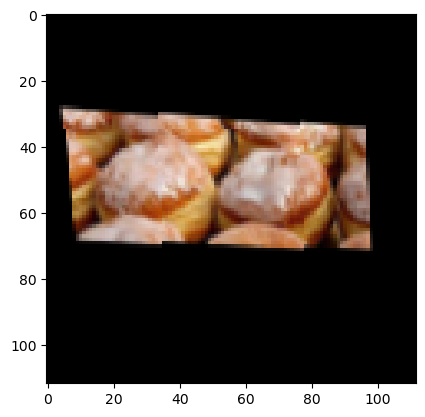

In [5]:
complete_dataset = np.asarray([[X_train[i], y_train[i]] for i in range(len(X_train))], dtype=object)

total_count = len(X_train)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    complete_dataset, (train_count, valid_count, test_count)
)

trainset = ImageDataset(train_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

testset = ImageDataset(test_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

validset = ImageDataset(valid_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

plt.imshow(data) 
plt.show()


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5, padding=2) 
        self.pool1 = nn.MaxPool2d(2, 2) # 56
        self.conv2 = nn.Conv2d(9, 27, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 28
        self.conv3 = nn.Conv2d(27, 81, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 14
        self.fc1 = nn.Linear(81 * 14 * 14, 1024)
        self.dropout1 = nn.Dropout1d(p = 0.5)
        self.fc2 = nn.Linear(1024, 128)
        
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.dropout1(self.fc2(x)))
        x = self.fc3(x)
        return x
    
net = ConvNet()
net.to(device=device);

Epoch: 1, loss: 0.268: 100%|██████████| 415/415 [01:47<00:00,  3.87it/s]


------ Epoch 1 ------
avg. Train loss: 0.42092502404408283
Test loss: 0.5364419651813195 | Test accuracy: 0.6196721347629047


Epoch: 2, loss: 0.371: 100%|██████████| 415/415 [01:46<00:00,  3.88it/s]


------ Epoch 2 ------
avg. Train loss: 0.4095867254647864
Test loss: 0.5452254810294167 | Test accuracy: 0.6095082012356304


Epoch: 3, loss: 0.494: 100%|██████████| 415/415 [01:47<00:00,  3.86it/s]


------ Epoch 3 ------
avg. Train loss: 0.4126669425562204
Test loss: 0.5522747582099476 | Test accuracy: 0.6121311505309871


Epoch: 4, loss: 0.332: 100%|██████████| 415/415 [01:47<00:00,  3.87it/s]


------ Epoch 4 ------
avg. Train loss: 0.3964164709470358
Test loss: 0.6220928386586612 | Test accuracy: 0.6245901638367137


Epoch: 5, loss: 0.342: 100%|██████████| 415/415 [01:45<00:00,  3.94it/s]


------ Epoch 5 ------
avg. Train loss: 0.3965653391128563
Test loss: 0.5256597863846137 | Test accuracy: 0.6081967265879522


Epoch: 6, loss: 0.291: 100%|██████████| 415/415 [01:48<00:00,  3.83it/s]


------ Epoch 6 ------
avg. Train loss: 0.3913821733859648
Test loss: 0.6389367282390594 | Test accuracy: 0.5914754154252224


Epoch: 7, loss: 0.353: 100%|██████████| 415/415 [01:44<00:00,  3.98it/s]


------ Epoch 7 ------
avg. Train loss: 0.3877603072358901
Test loss: 0.5380780882522708 | Test accuracy: 0.6186885286550052


Epoch: 8, loss: 0.302: 100%|██████████| 415/415 [01:50<00:00,  3.77it/s]


------ Epoch 8 ------
avg. Train loss: 0.3910954476480024
Test loss: 0.5590889312204768 | Test accuracy: 0.5990163957486387


Epoch: 9, loss: 0.43: 100%|██████████| 415/415 [01:48<00:00,  3.81it/s] 


------ Epoch 9 ------
avg. Train loss: 0.390916344882494
Test loss: 0.5497880973776833 | Test accuracy: 0.6167213135078305


Epoch: 10, loss: 0.346: 100%|██████████| 415/415 [01:45<00:00,  3.92it/s]


------ Epoch 10 ------
avg. Train loss: 0.3846485472228154
Test loss: 0.592926311688345 | Test accuracy: 0.6180327915754474


Epoch: 11, loss: 0.359: 100%|██████████| 415/415 [01:43<00:00,  4.01it/s]


------ Epoch 11 ------
avg. Train loss: 0.37969058884913665
Test loss: 0.664368917707537 | Test accuracy: 0.5960655764478152


Epoch: 12, loss: 0.334: 100%|██████████| 415/415 [01:46<00:00,  3.91it/s]


------ Epoch 12 ------
avg. Train loss: 0.3856830438217485
Test loss: 0.5302489228913041 | Test accuracy: 0.6262295109326722


Epoch: 13, loss: 0.331: 100%|██████████| 415/415 [01:47<00:00,  3.86it/s]


------ Epoch 13 ------
avg. Train loss: 0.383412884660514
Test loss: 0.538562644700535 | Test accuracy: 0.6147541017805944


Epoch: 14, loss: 0.502: 100%|██████████| 415/415 [01:44<00:00,  3.96it/s]


------ Epoch 14 ------
avg. Train loss: 0.3771422078092414
Test loss: 0.684183595121884 | Test accuracy: 0.5878688556249024


Epoch: 15, loss: 0.33: 100%|██████████| 415/415 [01:46<00:00,  3.89it/s] 


------ Epoch 15 ------
avg. Train loss: 0.3781468110630311
Test loss: 0.5795583710318706 | Test accuracy: 0.628196726079847


Epoch: 16, loss: 0.404: 100%|██████████| 415/415 [01:43<00:00,  4.03it/s]


------ Epoch 16 ------
avg. Train loss: 0.38461634491581514
Test loss: 0.6310435318555988 | Test accuracy: 0.5963934459647194


Epoch: 17, loss: 0.37: 100%|██████████| 415/415 [01:44<00:00,  3.98it/s] 


------ Epoch 17 ------
avg. Train loss: 0.3761698898780777
Test loss: 0.5082910832811575 | Test accuracy: 0.6373770515449712


Epoch: 18, loss: 0.341: 100%|██████████| 415/415 [01:43<00:00,  4.01it/s]


------ Epoch 18 ------
avg. Train loss: 0.3860183289611196
Test loss: 0.494959367103264 | Test accuracy: 0.6367213159311013


Epoch: 19, loss: 0.34: 100%|██████████| 415/415 [01:45<00:00,  3.95it/s] 


------ Epoch 19 ------
avg. Train loss: 0.37322570351232964
Test loss: 0.5856418096628345 | Test accuracy: 0.6147541017805944


Epoch: 20, loss: 0.406: 100%|██████████| 415/415 [01:45<00:00,  3.93it/s]


------ Epoch 20 ------
avg. Train loss: 0.3706019720040172
Test loss: 0.7318047118968651 | Test accuracy: 0.5993442696626069
Finished Training


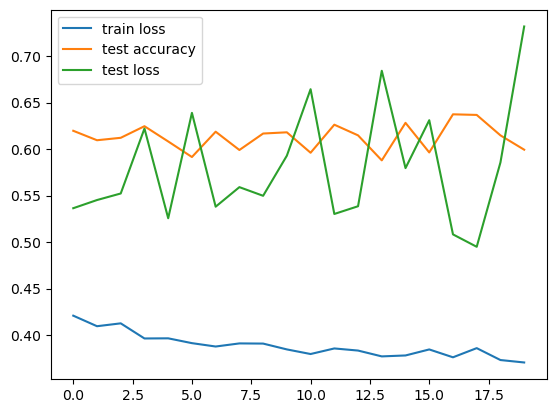

In [9]:
from tqdm import tqdm
import torch.optim as optim

# Fix random seed to get reproducibility
torch.manual_seed(42)

batch_size=50
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

train_losses = []
test_losses = []
test_accuracys = []
running_loss = []

for epoch in range(20):  # loop over the dataset multiple times

    # EXTRA: get a nice progress bar visualization
    train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=0.3)
    for i, data in enumerate(train_progress, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss.append(loss.item())
        train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")
    
    print(f"------ Epoch {epoch+1} ------")
    
    test_loss = 0
    test_accuracy = 0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
    test_loss = test_loss / len(test_dataloader)
    test_accuracy = test_accuracy / len(test_dataloader)
    
    test_accuracys.append(test_accuracy)
    test_losses.append(test_loss)
    train_losses.append(sum(running_loss)/(len(running_loss)))
    
    print(f"avg. Train loss: {sum(running_loss)/(len(train_dataloader))}")
    print(f"Test loss: {test_loss} | Test accuracy: {test_accuracy}")
    running_loss = []

print('Finished Training')
plt.plot(train_losses, label='train loss')
plt.plot(test_accuracys, label='test accuracy')
plt.plot(test_losses, label='test loss')

plt.legend()

In [ ]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from torchvision.transforms import RandomResizedCrop

"""
trainset = ImageDataset(y_train, X_train, transform=transforms.Compose([
    #RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.5,2))
]))
ml_dataloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)

impr_trainset_data = []
impr_trainset_labels = []
for batch in ml_dataloader:
    data, lbl = batch
    lbl = np.asarray(lbl)[0]
    data = np.asarray(data)
    data = np.moveaxis(data, 0, 2)
    impr_trainset_data.append(data)
    impr_trainset_labels.append(lbl)

impr_trainset_labels = np.asarray(impr_trainset_labels)    
impr_trainset_data = np.asarray(impr_trainset_data)
impr_trainset_data = impr_trainset_data.reshape(-1, 3 * 112 * 112)
""";
impr_trainset_data = X_train.reshape(-1, 3 * 112 * 112)
impr_trainset_labels = y_train

model = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', verbose=1)
model.fit(impr_trainset_data, impr_trainset_labels)

In [ ]:
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/ccd1103058108dca8975f3aa0e15024118d43058.bmp"
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/5d218a52d5657d1b40909b8805944b3f83b29c8d.bmp"
test_pic = Image.open(test_path)
test_data = np.asarray(test_pic)
test_data = (test_data / 255.0)
test_data = test_data.astype(np.float32)
test_data = test_data.reshape(-1, 3 , 112, 112)
test_data = torch.from_numpy(test_data)
test_data = test_data.reshape(-1, 3 * 112 * 112)

pred = model.predict(test_data)
pred

print(f'Actual value from test data is 0 and corresponding image is as below')
plt.matshow(test_data.reshape((112,112,3))) 
plt.show()
print(f'Predicted value from test data is {pred[0]} and corresponding image is as below')



In [10]:
val_loss = 0
val_accuracy = 0


valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)

for i, data in enumerate(valid_dataloader, 0):
    inputs, labels = data
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
    val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
val_loss = val_loss / len(valid_dataloader)
val_accuracy = val_accuracy / len(valid_dataloader)

print("accuracy: {}".format(val_accuracy))
print("loss: {}".format(val_loss))
    

accuracy: 0.6667796610169492
loss: 0.702613603469689
